In [1]:
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

from utils import UKF, PF, PPF
from utils import StateSpaceModel, MPCTrajectory, track_example1

In [2]:
x_points, y_points, line_segments = track_example1()

system = StateSpaceModel()

Ns = [10, 15, 20, 50, 100, 200, 500, 1000]

In [3]:
import numpy as np
from tqdm import tqdm

def run_experiment(num_repeats = 5):

    # Define the distribution types
    distribution_types = ['mvn', 'mvt']

    # Lists to store MSE values
    MSEs_PF_mvn_repeat = []
    MSEs_PF_mvt_repeat = []
    MSEs_PPF_mvn_repeat = []
    MSEs_PPF_mvt_repeat = []
    MSEs_UKF_mvn_repeat = []
    MSEs_UKF_mvt_repeat = []


    # Perform repeats
    for repeat in trange(num_repeats):
        # Lists to store MSE values for each repeat
        MSEs_PF_mvn = []
        MSEs_PF_mvt = []
        MSEs_PPF_mvn = []
        MSEs_PPF_mvt = []
        MSEs_UKF_mvn = []
        MSEs_UKF_mvt = []

        # Perform computations for each distribution type
        for dist_type in distribution_types:

            trajectory = MPCTrajectory(x_points, y_points, line_segments, noise_dist=dist_type, savepath=f"output/track_L1_{dist_type}.pkl")
            states, measurements = trajectory.get_data()


            for N in Ns:
                print(f"Repeat {repeat+1}/{num_repeats}, N = {N}, dist_type = {dist_type}")
                particle_filter = PF(f=system.f, h=system.h, Q=system.Q, R=system.R, dim_m = 4, dim_y = 2, N=N)
                state_estimates, _, _, _ = particle_filter.filter(measurements, verbose=False)

                if dist_type == 'mvn':
                    MSEs_PF_mvn.append(np.mean((states - state_estimates) ** 2))
                elif dist_type == 'mvt':
                    MSEs_PF_mvt.append(np.mean((states - state_estimates) ** 2))

                parzen_particle_filter = PPF(system.f, system.h, system.F_jacobian, system.Q, system.R, dim_m = 4, dim_y = 2, N=N)
                state_estimates, _, _, _ = parzen_particle_filter.filter(measurements, verbose=False)
                
                if dist_type == 'mvn':
                    MSEs_PPF_mvn.append(np.mean((states - state_estimates) ** 2))
                elif dist_type == 'mvt':   
                    MSEs_PPF_mvt.append(np.mean((states - state_estimates) ** 2))


            unscent_kalman_filter = UKF(system.f, system.h, system.Q, system.R)
            state_estimates, _ = unscent_kalman_filter.filter(measurements)

            if dist_type == 'mvn':
                MSEs_UKF_mvn.append(np.mean((states - state_estimates) ** 2))
            elif dist_type == 'mvt':
                MSEs_UKF_mvt.append(np.mean((states - state_estimates) ** 2))

        # Append the MSE values for each repeat to the repeat-level lists
        MSEs_PF_mvn_repeat.append(MSEs_PF_mvn)
        MSEs_PF_mvt_repeat.append(MSEs_PF_mvt)
        MSEs_PPF_mvn_repeat.append(MSEs_PPF_mvn)
        MSEs_PPF_mvt_repeat.append(MSEs_PPF_mvt)
        MSEs_UKF_mvn_repeat.append(MSEs_UKF_mvn)
        MSEs_UKF_mvt_repeat.append(MSEs_UKF_mvt)

        
    # Convert the repeat-level lists to arrays
    MSEs_PF_mvn_repeat = np.array(MSEs_PF_mvn_repeat)
    MSEs_PF_mvt_repeat = np.array(MSEs_PF_mvt_repeat)
    MSEs_PPF_mvn_repeat = np.array(MSEs_PPF_mvn_repeat)
    MSEs_PPF_mvt_repeat = np.array(MSEs_PPF_mvt_repeat)
    MSEs_UKF_mvn_repeat = np.array(MSEs_UKF_mvn_repeat)
    MSEs_UKF_mvt_repeat = np.array(MSEs_UKF_mvt_repeat)

    return MSEs_PF_mvn_repeat, MSEs_PF_mvt_repeat, MSEs_PPF_mvn_repeat, MSEs_PPF_mvt_repeat, MSEs_UKF_mvn_repeat, MSEs_UKF_mvt_repeat

In [4]:
# MSEs_PF_mvn_repeat, MSEs_PF_mvt_repeat, MSEs_PPF_mvn_repeat, MSEs_PPF_mvt_repeat, MSEs_UKF_mvn_repeat, MSEs_UKF_mvt_repeat = run_experiment(num_repeats=5)

# save the results
# np.savez('output/number_particles.npz',MSEs_PF_mvn_repeat=MSEs_PF_mvn_repeat, MSEs_PF_mvt_repeat=MSEs_PF_mvt_repeat, MSEs_PPF_mvn_repeat=MSEs_PPF_mvn_repeat, MSEs_PPF_mvt_repeat=MSEs_PPF_mvt_repeat, MSEs_UKF_mvn_repeat=MSEs_UKF_mvn_repeat, MSEs_UKF_mvt_repeat=MSEs_UKF_mvt_repeat)

# Load the results
results = np.load('output/number_particles.npz')
MSEs_PF_mvn_repeat = results['MSEs_PF_mvn_repeat']
MSEs_PF_mvt_repeat = results['MSEs_PF_mvt_repeat']
MSEs_PPF_mvn_repeat = results['MSEs_PPF_mvn_repeat']
MSEs_PPF_mvt_repeat = results['MSEs_PPF_mvt_repeat']
MSEs_UKF_mvn_repeat = results['MSEs_UKF_mvn_repeat']
MSEs_UKF_mvt_repeat = results['MSEs_UKF_mvt_repeat']

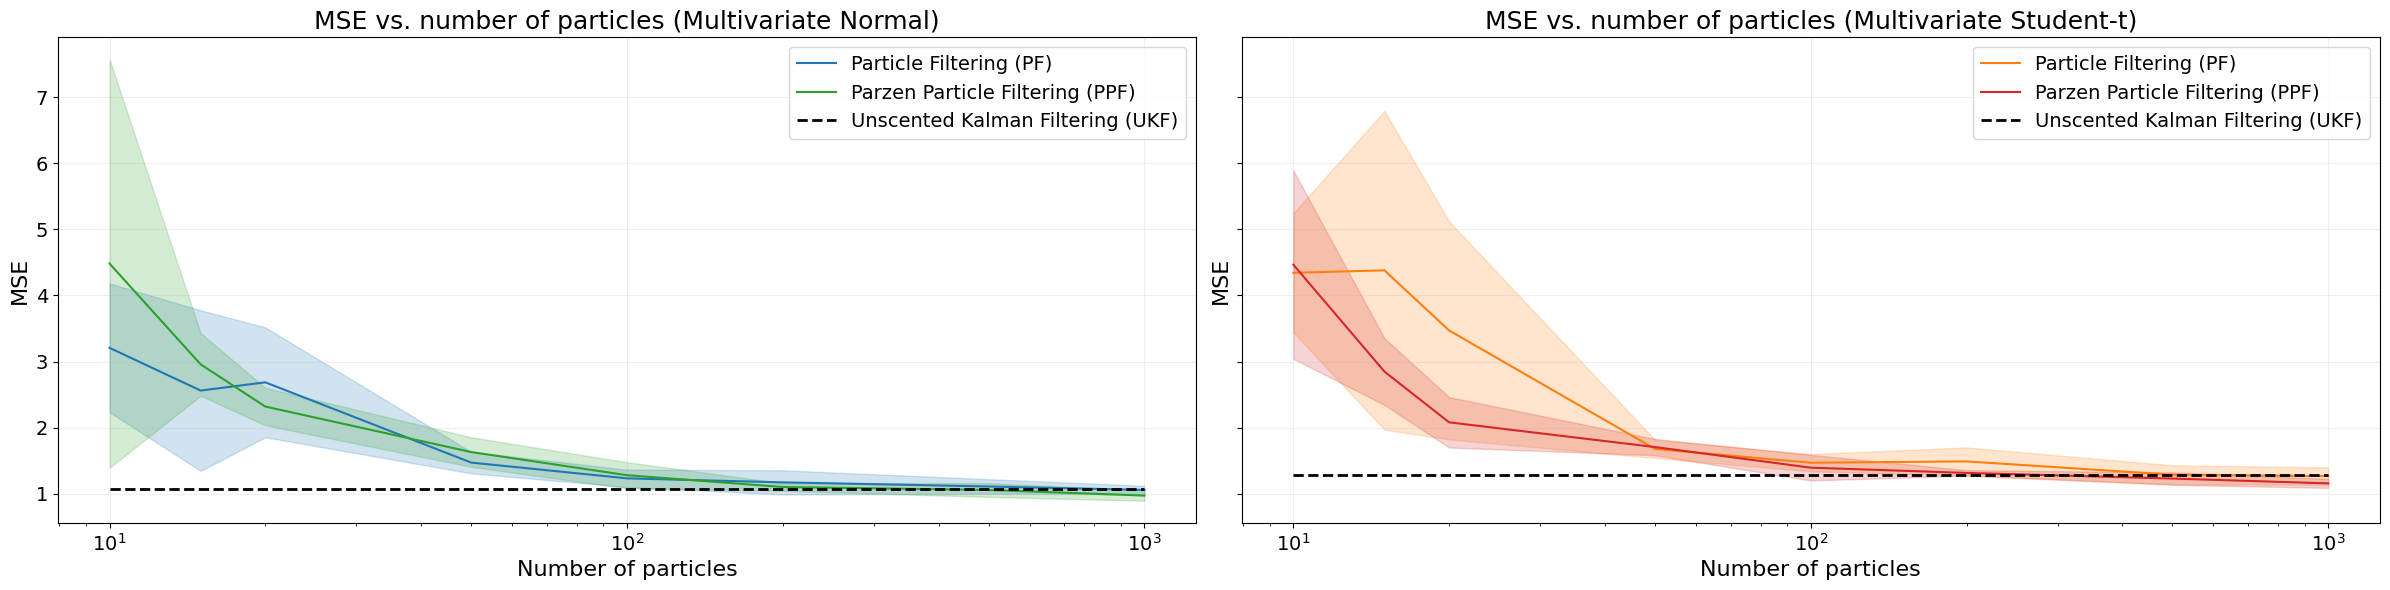

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6), sharey=True)

ax[0].plot(Ns, np.mean(MSEs_PF_mvn_repeat, axis=0), label='Particle Filtering (PF)', color='C0')
ax[0].fill_between(Ns, np.mean(MSEs_PF_mvn_repeat, axis=0) - np.std(MSEs_PF_mvn_repeat, axis=0), np.mean(MSEs_PF_mvn_repeat, axis=0) + np.std(MSEs_PF_mvn_repeat, axis=0), alpha=0.2, color='C0')

ax[0].plot(Ns, np.mean(MSEs_PPF_mvn_repeat, axis=0), label='Parzen Particle Filtering (PPF)', color='C2')
ax[0].fill_between(Ns, np.mean(MSEs_PPF_mvn_repeat, axis=0) - np.std(MSEs_PPF_mvn_repeat, axis=0), np.mean(MSEs_PPF_mvn_repeat, axis=0) + np.std(MSEs_PPF_mvn_repeat, axis=0), alpha=0.2, color='C2')

ax[0].hlines(MSEs_UKF_mvn_repeat.mean(), Ns[0], Ns[-1], label='Unscented Kalman Filtering (UKF)', color='k', linestyle='--', linewidth=2)

ax[0].set_title('MSE vs. number of particles (Multivariate Normal)', fontsize=18)


ax[1].plot(Ns, np.mean(MSEs_PF_mvt_repeat, axis=0), label='Particle Filtering (PF)', color='C1')
ax[1].fill_between(Ns, np.mean(MSEs_PF_mvt_repeat, axis=0) - np.std(MSEs_PF_mvt_repeat, axis=0), np.mean(MSEs_PF_mvt_repeat, axis=0) + np.std(MSEs_PF_mvt_repeat, axis=0), alpha=0.2, color='C1')

ax[1].plot(Ns, np.mean(MSEs_PPF_mvt_repeat, axis=0), label='Parzen Particle Filtering (PPF)', color='C3')
ax[1].fill_between(Ns, np.mean(MSEs_PPF_mvt_repeat, axis=0) - np.std(MSEs_PPF_mvt_repeat, axis=0), np.mean(MSEs_PPF_mvt_repeat, axis=0) + np.std(MSEs_PPF_mvt_repeat, axis=0), alpha=0.2, color='C3')

ax[1].hlines(MSEs_UKF_mvt_repeat.mean(), Ns[0], Ns[-1], label='Unscented Kalman Filtering (UKF)', color='k', linestyle='--', linewidth=2)

ax[1].set_title('MSE vs. number of particles (Multivariate Student-t)', fontsize=18)

for k in range(2):
    ax[k].grid(alpha=0.2)
    ax[k].set_xscale('log')
    ax[k].set_xlabel('Number of particles', fontsize=16)
    ax[k].set_ylabel('MSE', fontsize=16)
    ax[k].tick_params(axis='both', which='major', labelsize=14)
    ax[k].legend(fontsize=14)

plt.tight_layout()
plt.show()